In [1]:
import PIL
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstatsπ
from tqdm.notebook import tqdm

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
from scipy import stats, interpolate
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution

# Cubic Gaussian Integral

Using Monte Carlo integration check that

$$ 
\int_{0}^{+\infty} x^3 e^{\frac{-x^2}{2\sigma^2}}dx = 2 \sigma^4 
$$  

We know that a complex integral $\int{f(x)}dx$ can be computed numerically if 

1) $f(x)$ can be evaluated in any $x_i$
2) exists a $p(x)$ | $ \int{p(x)}dx = 1$

Then it is possible to write

$$ \int{f(x)}dx = \int{f(x)p(x)}dx \sim \frac{\sum_{i=1}^N f(x_i)}{N} $$

Looking at the integral to solve, we can take as $p(x) | \int{p(x)}=1$ the following gaussian integral with fixed $\mu = 0$ and $\sigma$

$$ 
2 \int_{0}^{+\infty} \frac{e^{\frac{-x^2}{2\sigma^2}}}{\sqrt{2 \pi} \sigma}dx = 1
$$

In fact:

In [2]:
def gauss(x,mu,sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

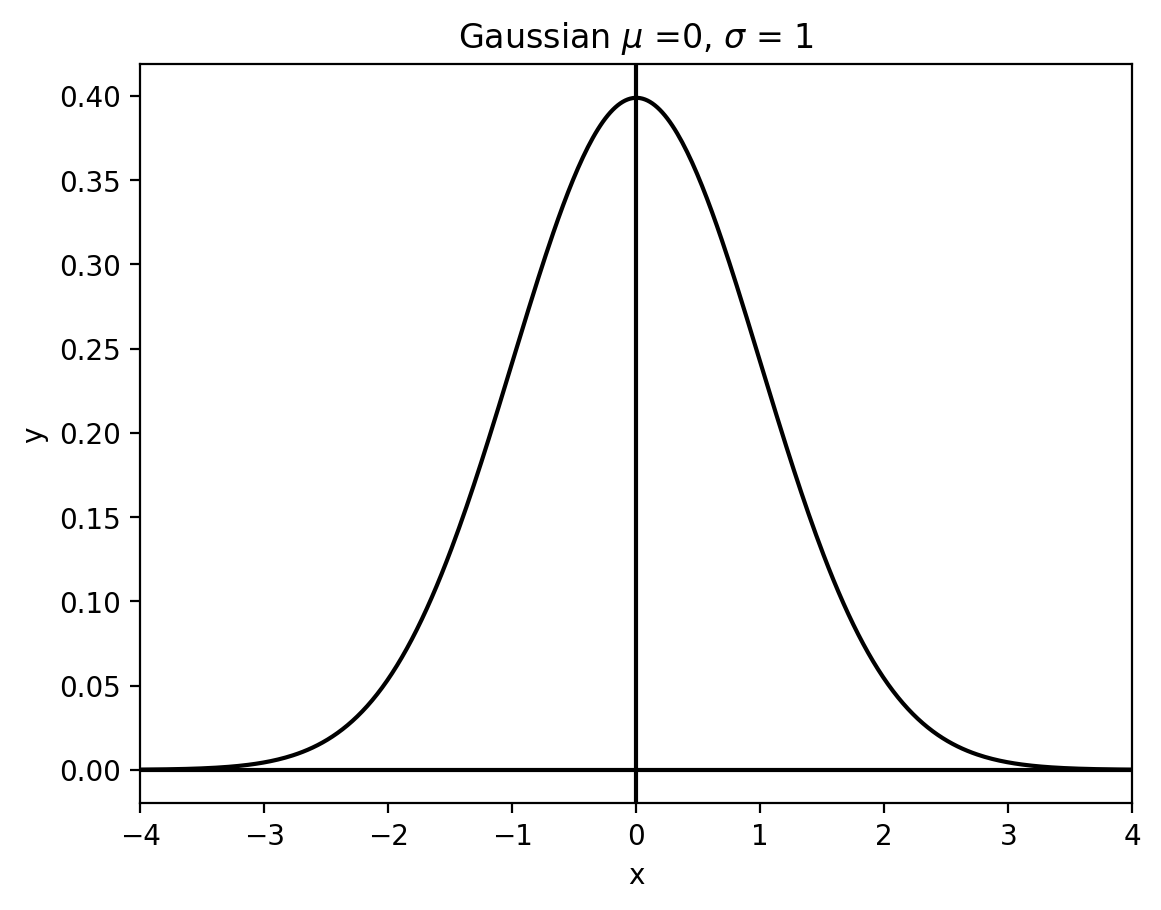

In [3]:
mu = 0     #fixed from the integral
sigma = 1

xgrid = np.linspace(-1000,1000,100000)
y = gauss(xgrid, mu, sigma)

plt.plot(xgrid, y, 'k')
plt.axvline(0, color='k', zorder=0)
plt.axhline(0, color='k', zorder=0)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian $\mu$ ='f'{mu}'', $\sigma$ = 'f'{sigma}')
plt.xlim(-4*sigma, 4*sigma)
plt.show()

And so now

$$ \int_{0}^{+\infty} x^3 e^{\frac{-x^2}{2\sigma^2}}dx = \frac{\sigma \sqrt{2 \pi}}{2} \int_{0}^{+\infty} 2\frac{e^{\frac{-x^2}{2\sigma^2}}}{\sigma \sqrt{2 \pi}}x^3dx  \sim mean(f(x_i))$$ 


## Solve the integral

Let's plot the Gaussian distribution and its cumulative (it should integrate to 1)

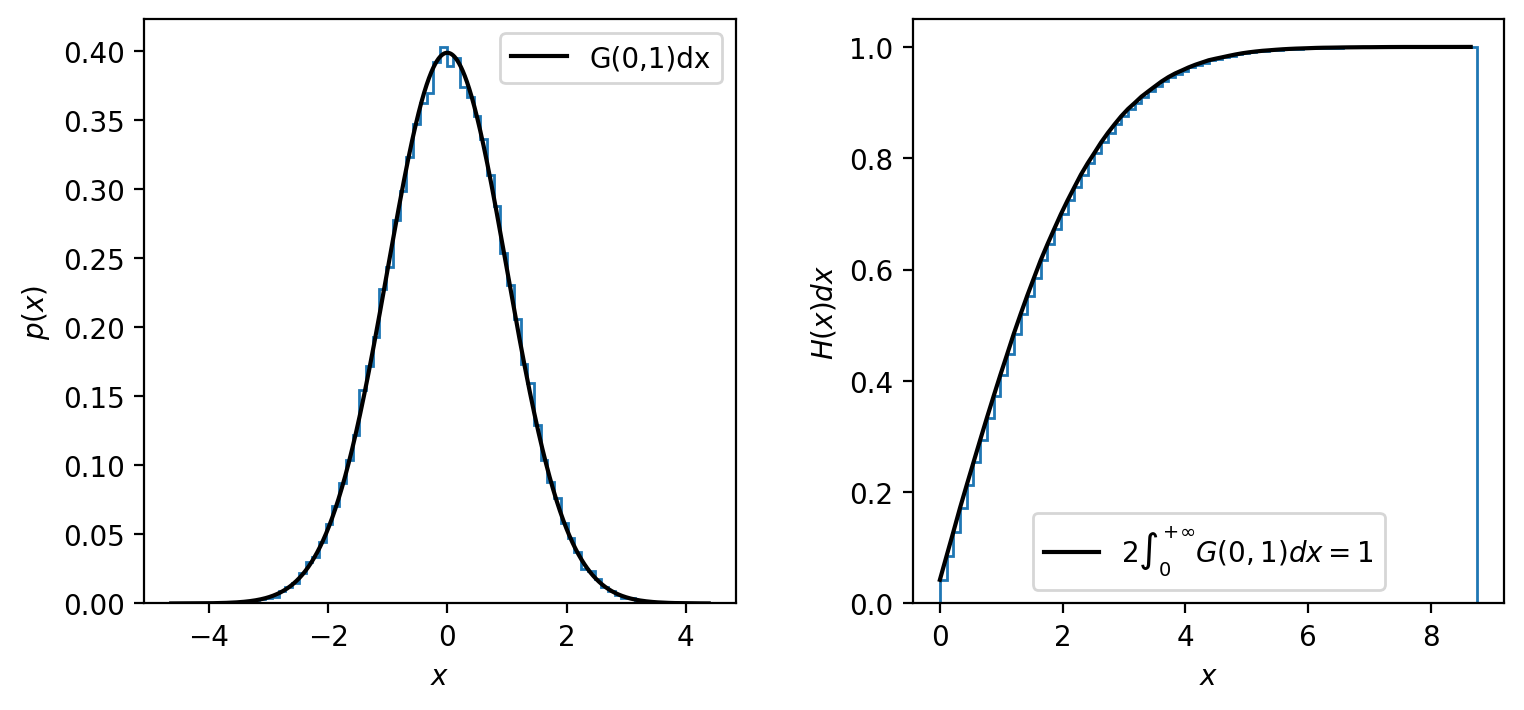

In [4]:
x_gaus = np.random.normal(mu,sigma, 100000)
x = np.sort(x_gaus)


fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)

# plot a histogram of the distrib
ax = fig.add_subplot(221)

hist(x_gaus, bins=80, histtype='step', density=True)
ax.plot(x, gauss(x,mu,sigma), 'k', label="G("f'{mu}'','f'{sigma}'")dx")
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.legend()

# plot cumulative of the distrib
ax = fig.add_subplot(222)

counts, bins, bars =hist(x_gaus[x_gaus >0]*2, bins=80, histtype='step', density=True,cumulative=True)
ax.plot(bins[:-1],counts,color='k', label="$2\int_{0}^{+\infty}{G("f'{mu}'','f'{sigma}'")dx}=1$")
ax.set_xlabel('$x$')
ax.set_ylabel('$H(x)dx$')
ax.legend()


plt.show()

### Compute the solution for growing sample points (N)

We should see that as N grows, the result of the Monte Carlo integration converges with the expected result of $2 \sigma^4$, shown in dashed red in the graph.

The "running mean" $\bar{R}$ of the results $R_i$ is computed as 

$$ \bar{R} = \sum_{i = 1}^{n} R_i$$ for n = 1, ..., N .


I have also computed the mean $I$ and the variance $s^2$ of the total N samples, that are shown in light blue in the graph below.

In [5]:
def func(x):
    return x**3

N = 1000

solution = np.zeros(N-1)
running_mean = np.zeros(N-1)

for i in range(1,N):
    x_gauss = np.random.normal(mu,sigma, N)
    x_i = x_gauss[x_gauss > 0]

    integral = sigma*np.sqrt(2*np.pi)/2*np.mean(func(x_i))
    solution[i-1] = integral
    running_mean[i-1] = np.mean(solution[:i])
        
mean_int = np.mean(solution)
var_int = np.sum((solution-mean_int)**2)/(N-1)
sol = 2*sigma**4

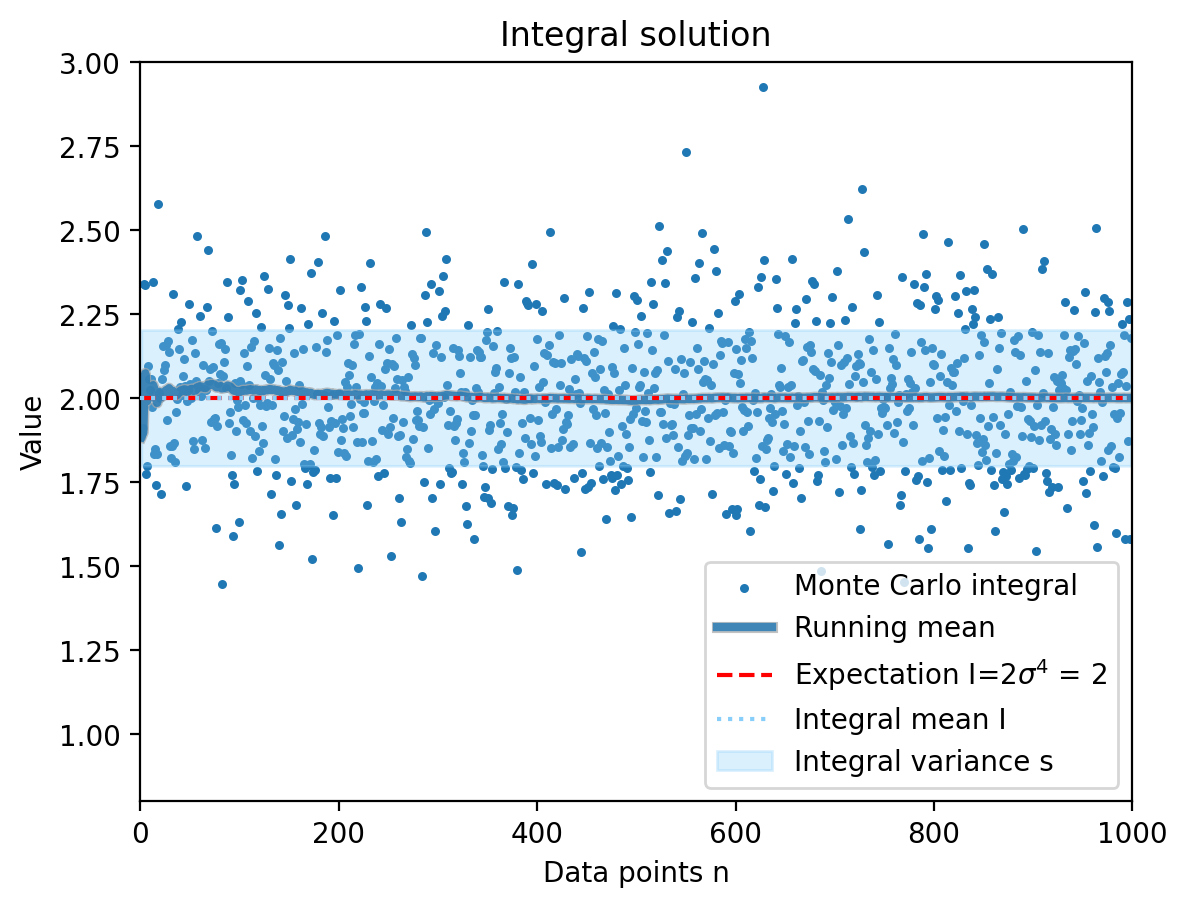

In [6]:
y1 = mean_int + np.sqrt(var_int)
y2 = mean_int - np.sqrt(var_int)

plt.scatter(np.arange(1,N), solution, s=5, label="Monte Carlo integral", zorder=0)
plt.plot(np.arange(1,N), running_mean, linewidth=3, label='Running mean', zorder=1, 
         alpha=0.8, path_effects=[pe.Stroke(linewidth=4, foreground='darkgray', alpha=0.7), pe.Normal()])

plt.axhline(sol,  color='red', linestyle='dashed', label="Expectation I=2$\sigma^4$ = "+str(sol), zorder=2)
plt.axhline(mean_int,  color='lightskyblue', linestyle='dotted', label="Integral mean I", zorder=3)
plt.fill_between(np.arange(1,N), y1, y2, color='lightskyblue', label='Integral variance s', alpha=0.3, zorder=0)

plt.xlabel('Data points n')
plt.ylabel('Value')
plt.ylim(sol*0.4,sol*1.5)
plt.xlim(0,N)
plt.title('Integral solution')
plt.legend(loc='lower right')
plt.show()

## Now let's compute the variance of the mean

The variation of the mean result $\sigma_I$ is:

$$\sigma_I = \frac{s}{\sqrt{n}} $$

Hence we should see that, as n increases (going from 2 to N), the variation of the mean decreases as $\sigma_I \propto \frac{1}{\sqrt{n}}$

In [7]:
mu_int = mean_int
var_n = np.zeros(N)
sigma_int = np.zeros(N)

for n in range(2,N):
    var_n[n] = np.sum((solution[:n]-mean_int)**2)/(n-1)
    sigma_int[n] = np.sqrt(var_n[n]/n)
sigma_int = sigma_int[2:]
n = np.arange(2,N)

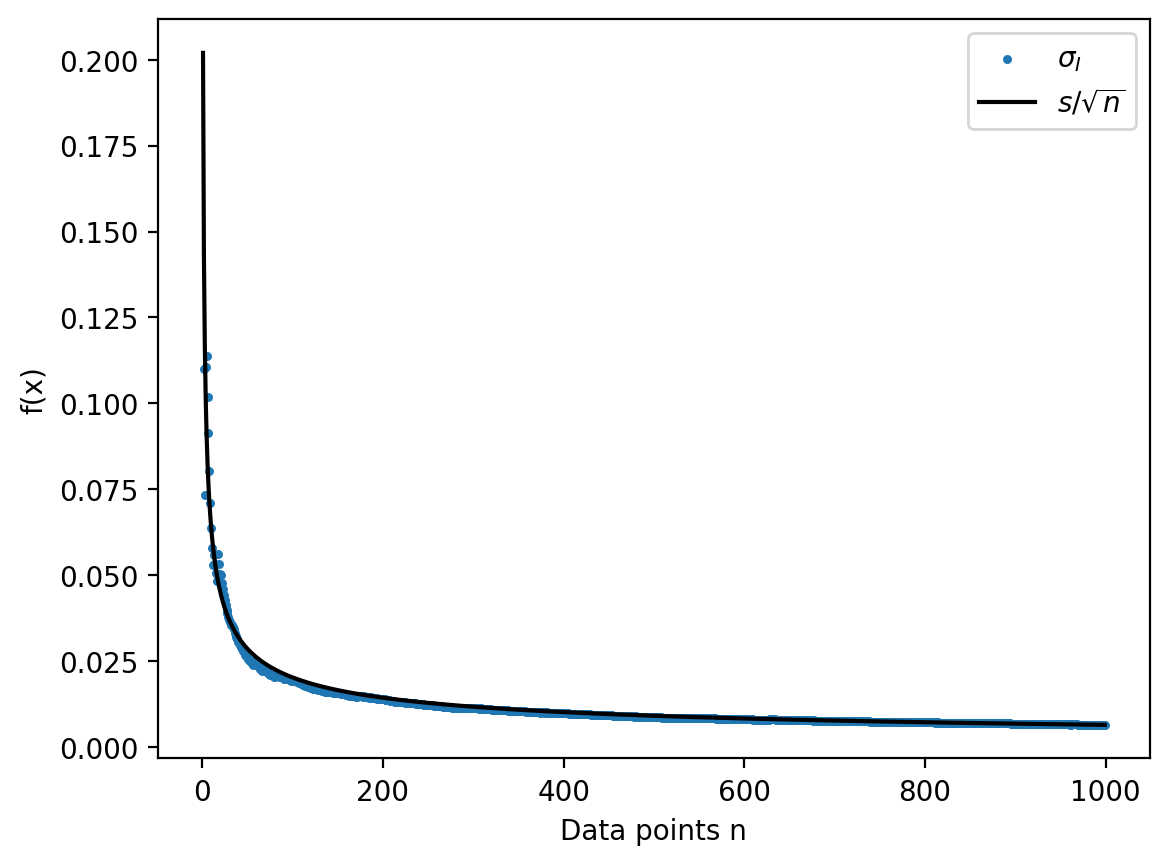

In [8]:
plt.scatter(n, sigma_int, s=5, label='$\sigma_{I}$')
plt.plot(np.arange(1,N), np.sqrt(var_int/np.arange(1,N)),'k', label = '$s/\sqrt{n}$')
plt.xlabel("Data points n")
plt.ylabel("f(x)")
plt.legend()
plt.show()

### Mean of the integral result

As expected, the mean $\bar{I}$ computed with Monte Carlo integration should converge to the true value of the $\mu$ of the distribution when the number of samples increases; wherease with increasing N the variance of the mean $\sigma_I$ should decrease.\
Also when N increases the histogram of the solution looks more and more gaussian, as it should be

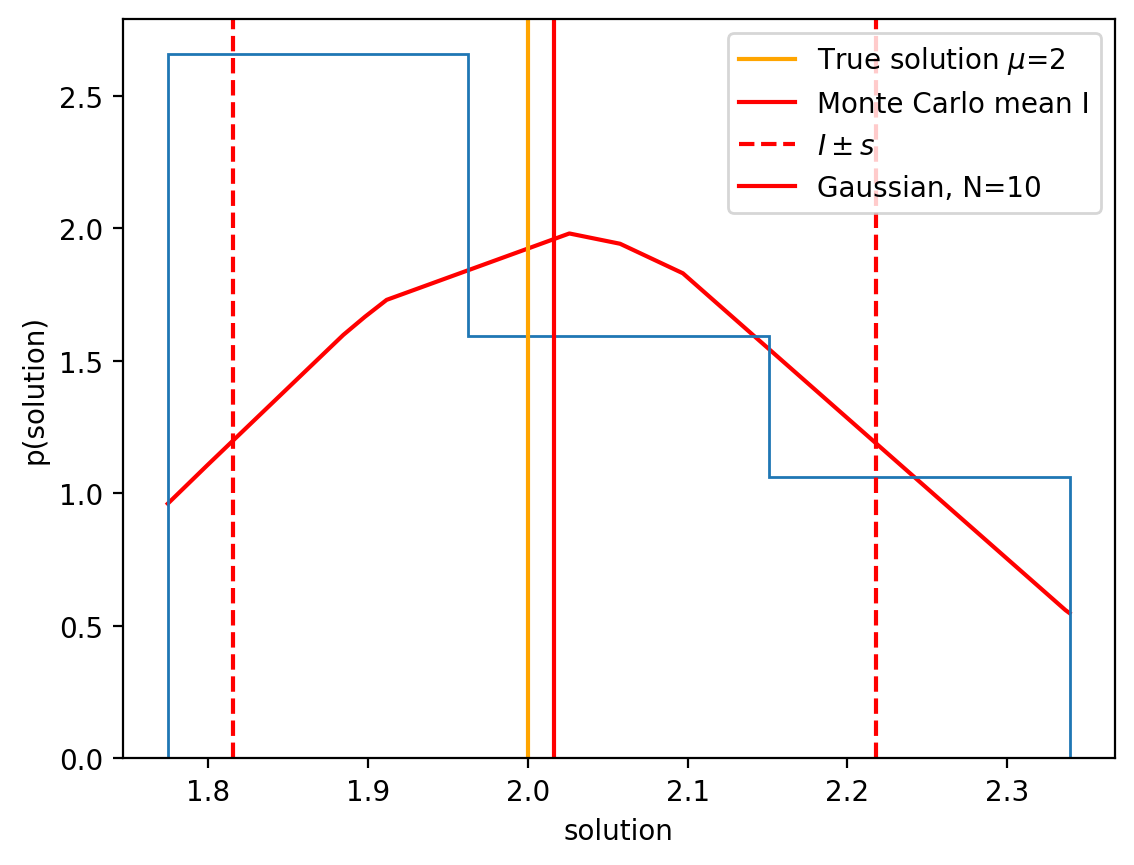

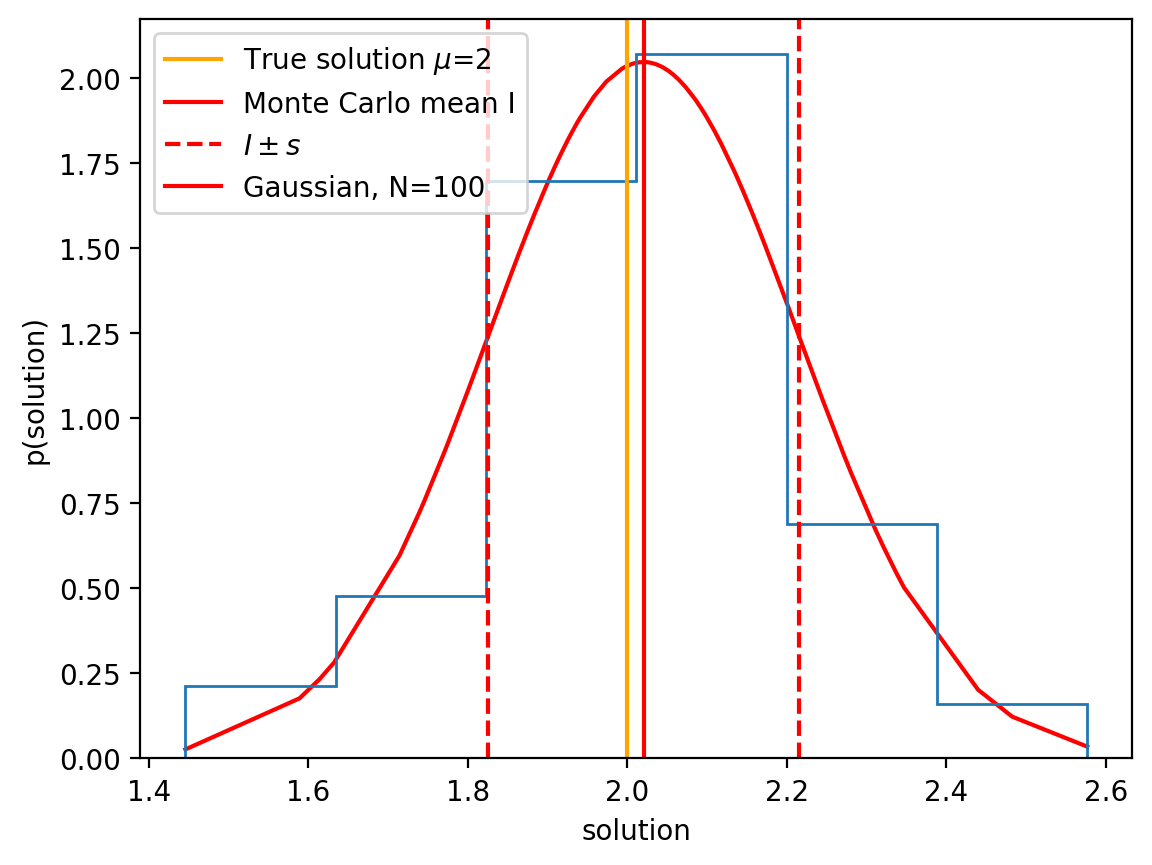

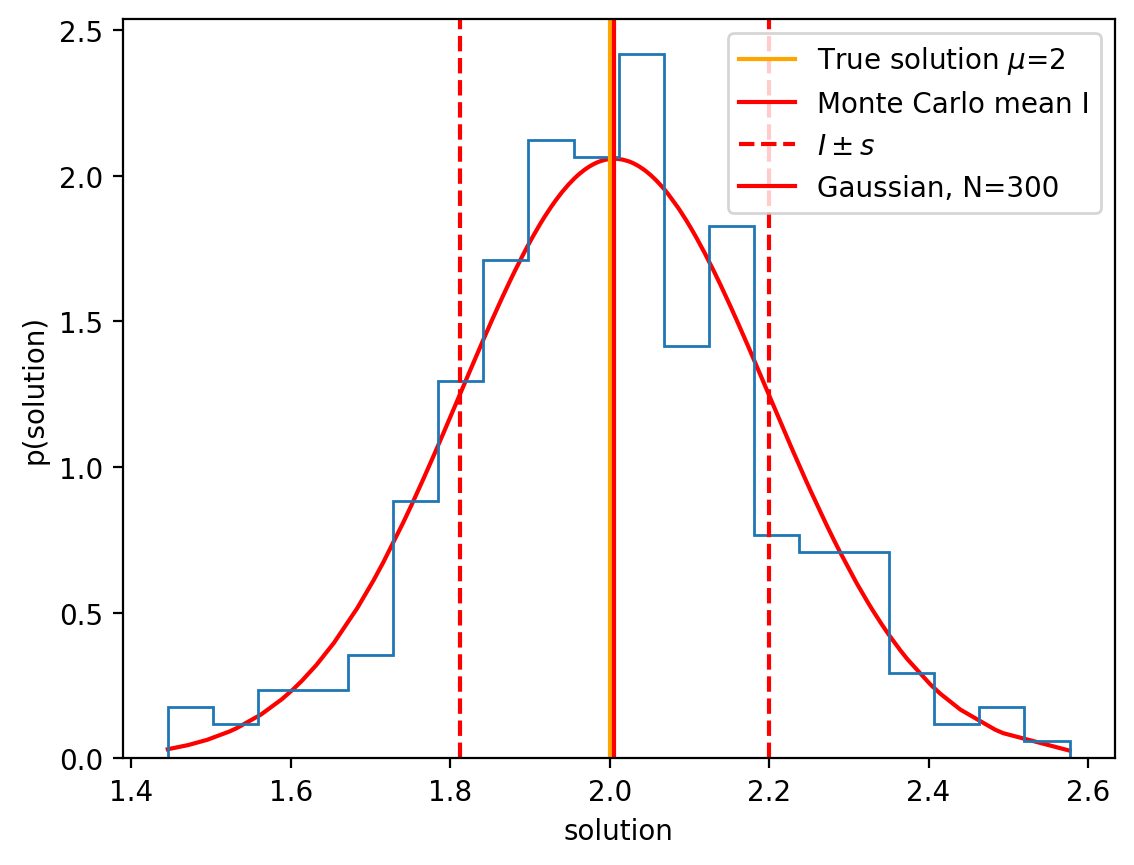

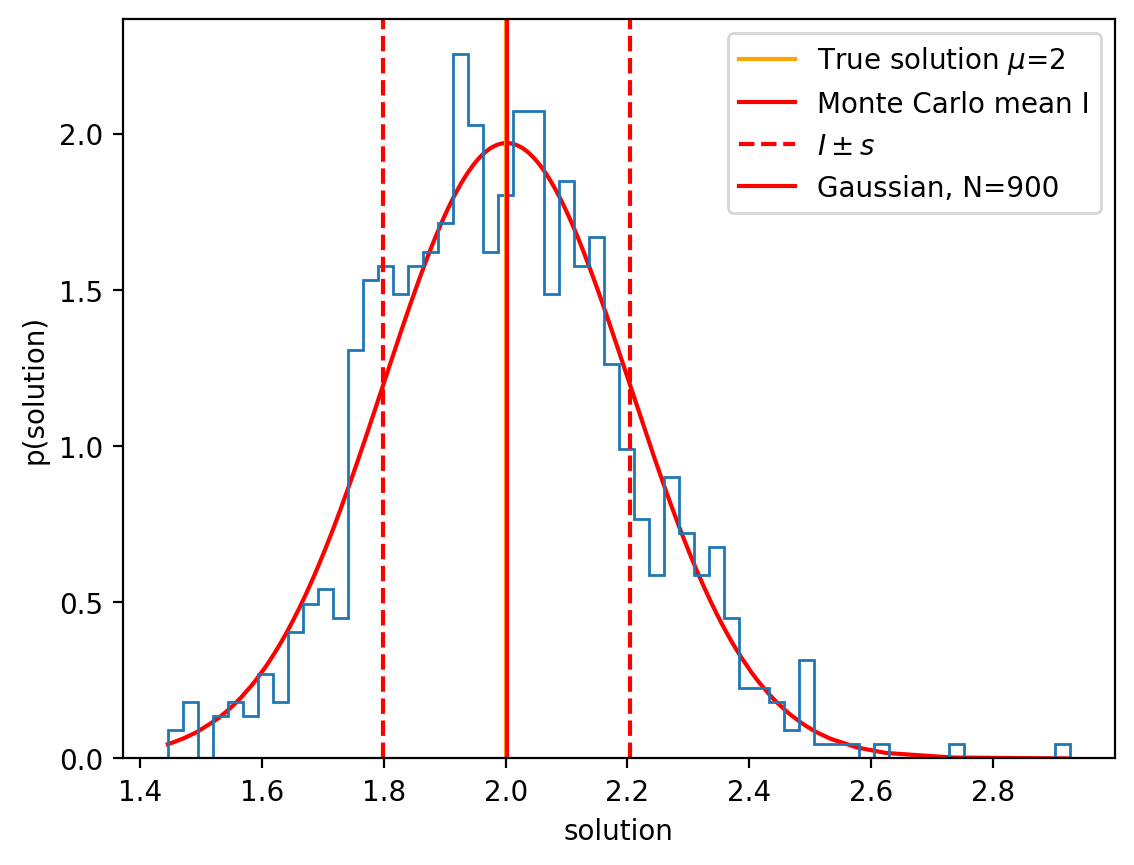

In [9]:
N_i = [100, 300, 900]
sqrt_var = np.sqrt(var_n)
mu_tot = running_mean

plt.hist(solution[:10], bins=3, density=True,histtype='step')
plt.axvline(sol, color='orange', label='True solution $\mu$='f'{sol}')
plt.axvline(mu_tot[10], color='r', label='Monte Carlo mean I')
plt.axvline(mu_tot[10] + sqrt_var[10], color='r', linestyle='dashed', label='$I \pm s$')
plt.axvline(mu_tot[10] - sqrt_var[10], color='r', linestyle='dashed')
plt.plot(np.sort(solution[:10]), gauss(np.sort(solution[:10]), mu_tot[10], 
                                       sqrt_var[10]), label='Gaussian, N=10', color='r', zorder=1)
plt.xlabel("solution")
plt.ylabel("p(solution)")
plt.legend()
plt.show()

for n_i in N_i:

    plt.hist(solution[:n_i], bins=int(n_i/15), density=True,histtype='step')
    plt.axvline(sol, color='orange', label='True solution $\mu$='f'{sol}')
    plt.axvline(mu_tot[n_i], color='r', label='Monte Carlo mean I')
    plt.axvline(mu_tot[n_i] + sqrt_var[n_i], color='r', linestyle='dashed', label='$I \pm s$')
    plt.axvline(mu_tot[n_i] - sqrt_var[n_i], color='r', linestyle='dashed')
    plt.plot(np.sort(solution[:n_i]), gauss(np.sort(solution[:n_i]), mu_tot[n_i], 
                                            sqrt_var[n_i]), label='Gaussian, N='f'{n_i}', color='r', zorder=1)
    plt.xlabel("solution")
    plt.ylabel("p(solution)")
    plt.legend()
    plt.show()